In [1]:
import contractions
import emoji
import string 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sn
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from google_trans_new import google_translator
from lingua import Language, LanguageDetectorBuilder


nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
detector = LanguageDetectorBuilder.from_all_languages().build()

# Using generic python library is not very accurate and google translate API is too slow
def detect_non_english(text):
    description_detection_1 = detector.detect_language_of(text[0]) # Returns top 2 detected language

    if(description_detection_1 != None): # Return description detection_1 since only 1 language was detected
        return description_detection_1


    if(description_detection_1 == None): # Check title for cross reference on language if description language is unknown
        
        title_detection_1= detector.detect_language_of(text[1])

        if(title_detection_1 == None): # Both are None
            return "Unknown"
        
        elif(title_detection_1 != None):
            return title_detection_1

    return "Unknown"
    

In [3]:
# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def remove_stopwords(reviews):
    STOPWORDS = stopwords.words('english')
    STOPWORDS.remove('not')
    STOPWORDS.remove('is')
    STOPWORDS.remove('but')
    if STOPWORDS is None:
        STOPWORDS = set(stopwords.words('english'))
    return ' '.join([word for word in reviews.split() if word not in STOPWORDS])

def remove_extra_whitespace(reviews):
    return " ".join(reviews.split())

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(reviews):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(reviews)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:]

def lower_case(review):
    
    return review.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(review):
    
    expanded_words = [contractions.fix(word) for word in review.split()]

    expanded_review = ' '.join(expanded_words)
    return expanded_review

# Remove Punctuations
def remove_punctuations(review):
    
    new_review = review.translate(str.maketrans('', '', string.punctuation))
    return new_review

# Remove numbers
def remove_numbers(review):
    
    mapping = str.maketrans('', '', string.digits)
    new_review = review.translate(mapping)
    
    return new_review

In [4]:

def clean_text(data):

    data['reviewDescription'] = data['reviewDescription'].apply(lower_case)
    data['reviewDescription'] = data['reviewDescription'].apply(change_contractions)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_emojis)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_punctuations)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_numbers)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_stopwords)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_extra_whitespace)
    data['reviewDescription'] = data['reviewDescription'].apply(lemmaSentence)
    
    return data

In [5]:
raw_dataset = pd.read_csv("raw_dataset/final_books_reviews_duplicates_removed.csv", encoding='utf8')
raw_dataset

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category
0,451524934,5,"9/11 false flag, Moon Landing hoax, JFK coup d...",12 people found this helpful,""" ' How is the dictionary getting on?' Said Wi...",True,humor_entertainment
1,451524934,5,Still a ‚ÄúMust read‚Äù for anyone‚Äôs booklist,NaN,"Not a happy or fun read, but still a must beca...",True,humor_entertainment
2,451524934,5,A book that expresses rebellion & individualism,10 people found this helpful,‚ÄúBooks like Orwell‚Äôs are powerful warnings...,True,humor_entertainment
3,451524934,5,Second greatest book ever written?,11 people found this helpful,"In short, Mr. Orwell (Blair) was a genius ahea...",True,humor_entertainment
4,451524934,5,Everyone should read this book.,NaN,Wow‚Ä¶ read this in high school and just rerea...,True,humor_entertainment
...,...,...,...,...,...,...,...
24324,1250316774,1,Just awful.,NaN,"Stupid plot, insipid characters. Nothing about...",True,children
24325,1250316774,1,So much blablabla,NaN,Don‚Äôt like the type of book that don‚Äôt foc...,True,children
24326,1250316774,1,"boring, predictable, 2 dimensional characters",NaN,I should have read more reviews before purchas...,False,children
24327,1250316774,1,Cringe,1,Characters taken right from a terrible rejecte...,True,children


In [6]:
data_df = raw_dataset.copy()

# Remove the non_english sentences 
data_df["reviewDescription"] = data_df["reviewDescription"].astype(str)
data_df['reviewTitle'] = data_df['reviewTitle'].astype(str)
data_df["languages"] = data_df[["reviewDescription", "reviewTitle"]].apply(detect_non_english, axis=1)

In [7]:
non_english_df = data_df[data_df["languages"]!=Language.ENGLISH]
non_english_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages
2,451524934,5,A book that expresses rebellion & individualism,10 people found this helpful,‚ÄúBooks like Orwell‚Äôs are powerful warnings...,True,humor_entertainment,Language.TAGALOG
13,451524934,5,Historia de todos los tiempos,NaN,"Este libro no pasa de moda, incre√≠ble que en ...",True,humor_entertainment,Language.SPANISH
93,451524934,5,It‚Äôs pretty good!,One person found this helpful,It‚Äôs pretty good!,True,humor_entertainment,Language.SLOVAK
212,451524934,3,Not finished,NaN,Not sure haven‚Äôt finished yet,True,humor_entertainment,Language.TAGALOG
295,451524934,5,Scary book- too close to home!,NaN,This book is like what our country is going to...,True,humor_entertainment,Language.TAGALOG
...,...,...,...,...,...,...,...,...
24287,1250316774,1,Paperback √© muito ruim,1,Al√©m de ser um pre√ßo absurdo o paperback √© ...,True,children,Language.PORTUGUESE
24288,1250316774,1,"je krijgt verschillende boeken door elkaar, ma...",NaN,De eerste 25 pagina's zijn van een ander boek....,True,children,Language.DUTCH
24299,1250316774,1,Blah,NaN,"I did not enjoy this book. I‚Äôm sorry, I just...",False,children,Language.TAGALOG
24312,1250316774,1,For teens,NaN,30F and wasn‚Äôt into it at all. It‚Äôs young ...,True,children,Language.SWEDISH


In [8]:
data_df[data_df["languages"]==Language.ENGLISH].to_csv('raw_dataset/final_books_reviews_duplicates_removed_english_only.csv')
data_df_english = data_df[data_df["languages"]==Language.ENGLISH].copy()

In [9]:
from transformers import pipeline
import pytorch_pretrained_bert as ppb
assert 'bert-large-cased' in ppb.modeling.PRETRAINED_MODEL_ARCHIVE_MAP
classifier_pipeline = pipeline ("zero-shot-classification", model = "facebook/bart-large-mnli")
from ipywidgets import IntProgress

In [10]:
from sklearn.model_selection import train_test_split
# Split train and test dataset. Test dataset will be self_annotated
train_df, test_df = train_test_split(data_df_english, test_size=0.1, random_state=42)

In [11]:
train_df['concat_review'] = train_df["reviewTitle"] + ". " + train_df["reviewDescription"]
train_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review
9406,B08NLXR9V5,4,Girl Alone,One person found this helpful,"My first Blake Pierce book was enjoyable, fast...",True,mystery,Language.ENGLISH,Girl Alone. My first Blake Pierce book was enj...
5701,670062510,5,A great book for young people. It has a great...,NaN,My favorite book when I was young. I read it ...,True,children,Language.ENGLISH,A great book for young people. It has a great...
13621,1542046599,1,More gripes than hypes,One person found this helpful,This is the first book I‚Äôve read by this aut...,True,mystery,Language.ENGLISH,More gripes than hypes. This is the first book...
5021,399226907,5,Add this book to your collection,NaN,Cute and educational book to teach counting an...,True,children,Language.ENGLISH,Add this book to your collection. Cute and edu...
21354,125030170X,2,Just okay.,NaN,This is one of those books you can read in a c...,False,children,Language.ENGLISH,Just okay.. This is one of those books you can...
...,...,...,...,...,...,...,...,...,...
12474,1542046599,5,Great read; couldn‚Äôt put it down,NaN,The first chapter reads from an odd point of v...,True,mystery,Language.ENGLISH,Great read; couldn‚Äôt put it down. The first ...
22518,125030170X,1,Used books?,NaN,They are purchased as new and I received the o...,True,children,Language.ENGLISH,Used books?. They are purchased as new and I r...
5670,670062510,4,My 7th graders not only love this book but the...,NaN,My 7th graders not only love this book but the...,True,children,Language.ENGLISH,My 7th graders not only love this book but the...
891,B01IW9TM5O,5,One of my favorite books ever - read almost al...,One person found this helpful,One of my favorite books ever - read almost al...,True,humor_entertainment,Language.ENGLISH,One of my favorite books ever - read almost al...


In [12]:
from tqdm import tqdm
label = ['positive', 'neutral', 'negative']

# To increase the accuracy on the annotation, I want to use the reviewTitle in addition to the description 

# Annotation using zero shot classification on training dataset
tqdm.pandas()
train_df['score_description'] = train_df['concat_review'].progress_apply(lambda review: classifier_pipeline(review, label))

100%|██████████| 20961/20961 [7:21:23<00:00,  1.26s/it]   


In [13]:
train_df['dict_score']  = train_df['score_description'].apply(lambda score_dict: {score_dict['labels'][0]:score_dict['scores'][0] ,  score_dict['labels'][1]: score_dict['scores'][1], score_dict['labels'][2]: score_dict['scores'][2]} )
train_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,score_description,dict_score
9406,B08NLXR9V5,4,Girl Alone,One person found this helpful,"My first Blake Pierce book was enjoyable, fast...",True,mystery,Language.ENGLISH,Girl Alone. My first Blake Pierce book was enj...,{'sequence': 'Girl Alone. My first Blake Pierc...,"{'positive': 0.9145709872245789, 'neutral': 0...."
5701,670062510,5,A great book for young people. It has a great...,NaN,My favorite book when I was young. I read it ...,True,children,Language.ENGLISH,A great book for young people. It has a great...,{'sequence': 'A great book for young people. ...,"{'positive': 0.8417089581489563, 'neutral': 0...."
13621,1542046599,1,More gripes than hypes,One person found this helpful,This is the first book I‚Äôve read by this aut...,True,mystery,Language.ENGLISH,More gripes than hypes. This is the first book...,{'sequence': 'More gripes than hypes. This is ...,"{'negative': 0.9657304883003235, 'neutral': 0...."
5021,399226907,5,Add this book to your collection,NaN,Cute and educational book to teach counting an...,True,children,Language.ENGLISH,Add this book to your collection. Cute and edu...,{'sequence': 'Add this book to your collection...,"{'positive': 0.8145831227302551, 'neutral': 0...."
21354,125030170X,2,Just okay.,NaN,This is one of those books you can read in a c...,False,children,Language.ENGLISH,Just okay.. This is one of those books you can...,{'sequence': 'Just okay.. This is one of those...,"{'neutral': 0.6949624419212341, 'positive': 0...."
...,...,...,...,...,...,...,...,...,...,...,...
12474,1542046599,5,Great read; couldn‚Äôt put it down,NaN,The first chapter reads from an odd point of v...,True,mystery,Language.ENGLISH,Great read; couldn‚Äôt put it down. The first ...,{'sequence': 'Great read; couldn‚Äôt put it do...,"{'positive': 0.9794765114784241, 'neutral': 0...."
22518,125030170X,1,Used books?,NaN,They are purchased as new and I received the o...,True,children,Language.ENGLISH,Used books?. They are purchased as new and I r...,{'sequence': 'Used books?. They are purchased ...,"{'negative': 0.8102515339851379, 'neutral': 0...."
5670,670062510,4,My 7th graders not only love this book but the...,NaN,My 7th graders not only love this book but the...,True,children,Language.ENGLISH,My 7th graders not only love this book but the...,{'sequence': 'My 7th graders not only love thi...,"{'positive': 0.9479295611381531, 'negative': 0..."
891,B01IW9TM5O,5,One of my favorite books ever - read almost al...,One person found this helpful,One of my favorite books ever - read almost al...,True,humor_entertainment,Language.ENGLISH,One of my favorite books ever - read almost al...,{'sequence': 'One of my favorite books ever - ...,"{'positive': 0.9317080974578857, 'neutral': 0...."


In [14]:
def find_best_polarity(data):

    best_polarity_score = max(data['positive'], data['neutral'], data['negative'])

    if(best_polarity_score == data["positive"]):
        return 1

    if(best_polarity_score == data["neutral"]):
        return 0

    if(best_polarity_score == data["negative"]):
        return -1

    
train_df['polarity'] = train_df['dict_score'].apply(find_best_polarity)

# Remove the un-necessary columns
train_df.drop(columns = ["score_description", "dict_score"], inplace = True)
train_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity
9406,B08NLXR9V5,4,Girl Alone,One person found this helpful,"My first Blake Pierce book was enjoyable, fast...",True,mystery,Language.ENGLISH,Girl Alone. My first Blake Pierce book was enj...,1
5701,670062510,5,A great book for young people. It has a great...,NaN,My favorite book when I was young. I read it ...,True,children,Language.ENGLISH,A great book for young people. It has a great...,1
13621,1542046599,1,More gripes than hypes,One person found this helpful,This is the first book I‚Äôve read by this aut...,True,mystery,Language.ENGLISH,More gripes than hypes. This is the first book...,-1
5021,399226907,5,Add this book to your collection,NaN,Cute and educational book to teach counting an...,True,children,Language.ENGLISH,Add this book to your collection. Cute and edu...,1
21354,125030170X,2,Just okay.,NaN,This is one of those books you can read in a c...,False,children,Language.ENGLISH,Just okay.. This is one of those books you can...,0
...,...,...,...,...,...,...,...,...,...,...
12474,1542046599,5,Great read; couldn‚Äôt put it down,NaN,The first chapter reads from an odd point of v...,True,mystery,Language.ENGLISH,Great read; couldn‚Äôt put it down. The first ...,1
22518,125030170X,1,Used books?,NaN,They are purchased as new and I received the o...,True,children,Language.ENGLISH,Used books?. They are purchased as new and I r...,-1
5670,670062510,4,My 7th graders not only love this book but the...,NaN,My 7th graders not only love this book but the...,True,children,Language.ENGLISH,My 7th graders not only love this book but the...,1
891,B01IW9TM5O,5,One of my favorite books ever - read almost al...,One person found this helpful,One of my favorite books ever - read almost al...,True,humor_entertainment,Language.ENGLISH,One of my favorite books ever - read almost al...,1


In [15]:
# Check if pos & neg are balanced from zero shot classfication
train_df["polarity"].value_counts()

 1    13246
-1     7518
 0      197
Name: polarity, dtype: int64

In [16]:
# Inter-annotator agreement between rating score and zero shot classiication

def rating_polarity(data):
    if(data < 3):
        return -1
    elif(data>3):
        return 1
    else:
        return 0



In [17]:
rating_score= train_df['ratingScore'].apply(rating_polarity)

rating_score.value_counts()

 1    14060
-1     5946
 0      955
Name: ratingScore, dtype: int64

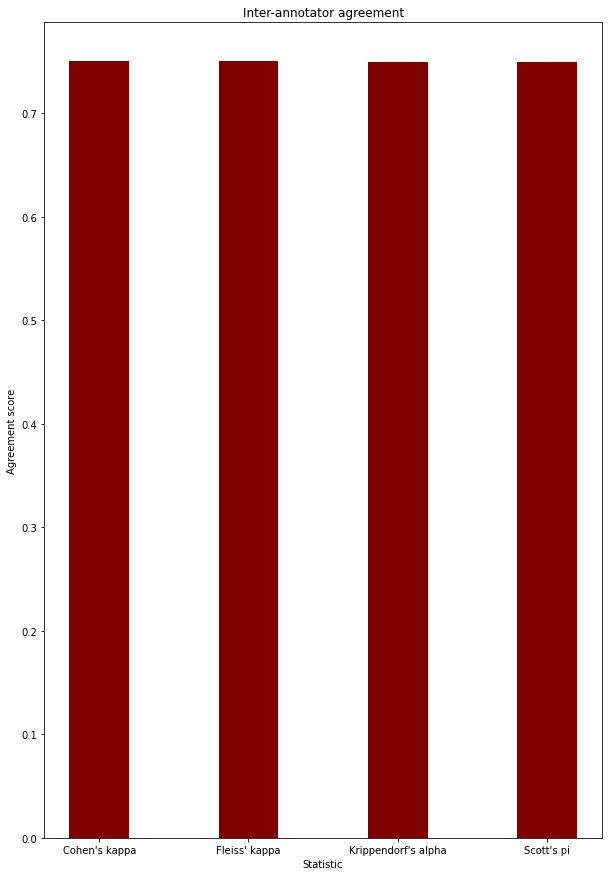

In [18]:
from nltk import agreement
import matplotlib.pyplot as plt

annotator_1 = train_df["polarity"].to_numpy()
annotator_2 = rating_score.to_numpy()

taskdata=[[0,str(i),str(annotator_1[i])] for i in range(0,len(annotator_1))]+[[1,str(i),str(annotator_2[i])] for i in range(0,len(annotator_2))]
ratingtask = agreement.AnnotationTask(data=taskdata)

cohen_kappa = ratingtask.kappa()
fleiss_kappa = ratingtask.multi_kappa()
krippendorf_alpha = ratingtask.alpha()
scotts_pi = ratingtask.pi()

scores = {"Cohen's kappa": cohen_kappa, "Fleiss' kappa": fleiss_kappa, "Krippendorf's alpha": krippendorf_alpha, "Scott's pi" : scotts_pi}

statistic = list(scores.keys())
values = list(scores.values())

fig = plt.figure(figsize = (10, 15))
plt.bar(statistic, values, color ='maroon',
        width = 0.4)
plt.xlabel("Statistic")
plt.ylabel("Agreement score")
plt.title("Inter-annotator agreement")
plt.show()


In [19]:
print(values)

[0.7504626056425071, 0.7504626056425071, 0.7493526452625605, 0.7493466662221098]


In [20]:
# Split test_dataset into 3 for annotations

print(test_df.shape[0])

2330


In [21]:
train_df.to_csv("train_test_dataset/train_df_imbalanced.csv")

In [23]:
test_df_1 = test_df.iloc[:776,:]
test_df_2 = test_df.iloc[776:1552,:]
test_df_3 = test_df.iloc[1552:,:]

In [24]:
test_df_1

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages
22808,1501161938,1,Predictable and trite.,2,If you assume white straight men are all idiot...,False,children,Language.ENGLISH
7497,1589255518,5,Classic Bedtime Story,NaN,This is one of my children‚Äôs all time favori...,True,children,Language.ENGLISH
170,451524934,5,We are living 1984,2 people found this helpful,You can thank Brandon for that,True,humor_entertainment,Language.ENGLISH
7470,B01M0JHBEG,5,Baby LOVES this book and so does mom!,NaN,The illustrations and lift the flaps are just ...,True,children,Language.ENGLISH
8608,141501596,5,Lovely,NaN,This is a classic! I loved this book as a kid ...,True,children,Language.ENGLISH
...,...,...,...,...,...,...,...,...
22580,125030170X,1,No,NaN,Just awful!,False,children,Language.ENGLISH
21540,125030170X,2,Bored,NaN,I was so bored reading this book. I switched o...,True,children,Language.ENGLISH
23190,194563183X,1,Ugh!,2,"Ugh! Too wordy, predictable and shallow. I am ...",True,children,Language.ENGLISH
2730,1982185821,5,A story that made me cry,One person found this helpful,I have so many fond memories of Sam from Iclar...,True,humor_entertainment,Language.ENGLISH


In [25]:
test_df_2

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages
3685,63076098,5,Worth Everything,One person found this helpful,"Without Kurt, we might not have gotten Dave an...",True,humor_entertainment,Language.ENGLISH
282,451524934,4,The story keeps you engaged as well as having ...,2 people found this helpful,I originally read this book back in high schoo...,True,humor_entertainment,Language.ENGLISH
8085,1484707230,5,Great read,NaN,Will keep a young reader turning pages.,True,children,Language.ENGLISH
8514,141501596,5,Book gift,NaN,I love this for baby shower gifts and birthday...,True,children,Language.ENGLISH
13070,1542046599,5,Fantastic!!,NaN,I'm so glad I downloaded this book - I am a ne...,True,mystery,Language.ENGLISH
...,...,...,...,...,...,...,...,...
6866,1641526270,5,A great beginning book that will teach my Gran...,NaN,Great Book and Teaching Tool!,True,children,Language.ENGLISH
5999,578629097,5,A must add to your collection!,NaN,"As a former teacher, I can tell you I really w...",True,children,Language.ENGLISH
17498,399587683,3,Proposal...For Realü§®!,NaN,This was yet another cute and fun read in this...,True,romance,Language.ENGLISH
18479,1647222613,1,1000% Not Worth it,NaN,With every pocket I open I have high hopes but...,True,humor_entertainment,Language.ENGLISH


In [26]:
test_df_3

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages
16198,1984806734,5,Gus and January!,NaN,I desperately wanted to read the last third of...,True,romance,Language.ENGLISH
11211,1542046599,5,Intriguing,NaN,This book was very intriguing! I was guessing ...,True,mystery,Language.ENGLISH
8061,1484707230,5,Great series,NaN,My kid is 8. He loved reading these series at ...,True,children,Language.ENGLISH
23710,399562494,1,Seems like a plagiarism of The Book Woman of T...,11,How can I give even one star for Jojo Moyes bo...,False,children,Language.ENGLISH
19796,145217380X,1,John Oliver - you have outdone yourself this time,3,Thoroughly enjoyed reading this fun book. Hope...,True,children,Language.ENGLISH
...,...,...,...,...,...,...,...,...
5161,399226907,5,Perfect Little Board Book,NaN,"I purchased the board book version, which is t...",True,children,Language.ENGLISH
10559,1542046599,5,Twists and Turns Abound,NaN,"A great suspenseful, ""Who Done It"". I couldn'...",True,mystery,Language.ENGLISH
7199,B01M0JHBEG,5,we love lift the flaps!,NaN,"This book is a lot of fun for Halloween, with ...",True,children,Language.ENGLISH
8504,141501596,5,Books ~ the Knowledge Source,NaN,"""June & Jack must read three books before they...",True,children,Language.ENGLISH


In [27]:
test_df_1.to_csv("train_test_dataset/test_df_Kelvin.csv")
test_df_2.to_csv("train_test_dataset/test_df_Bryson.csv")
test_df_3.to_csv("train_test_dataset/test_df_Gx.csv")